In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import optuna
from catboost import CatBoostClassifier
warnings.simplefilter('ignore', FutureWarning)

!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

In [3]:
train_df = pd.read_csv('/kaggle/input/data-all/train_all/train_all.csv')
test_df = pd.read_csv('/kaggle/input/data-all/train_all/test_all.csv')

In [4]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

## Chuẩn hóa

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Chọn feature

In [6]:
top_features = ['B14B', 'I2B', 'TCLW', 'R500', 'R850', 'CAPE', 'U850', 'B10B', 'PEV', 'SLOR', 'R250', 'KX', 'V250', 'U250', 'TCWV']

## Hàm bổ trợ

In [7]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

total = neg + pos

# Tính trọng số tỉ lệ nghịch với tần suất
w0 = total / (2 * neg) 
w1 = total / (2 * pos) 

class_weights = [w0, w1]
print(f"class_weights = {class_weights}")

class_weights = [0.5451356660527932, 6.038857002964938]


In [8]:
def print_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred))

In [9]:
def train_and_evaluate_cat(X_train, y_train, X_test, y_test, class_weights=None,  top_features=None):
    model_catboost = CatBoostClassifier(
        random_state=42,
        verbose=0,  
        class_weights=class_weights
    )

    if top_features is not None:
        X_train = X_train[top_features]
        X_test = X_test[top_features]

    model_catboost.fit(X_train, y_train)
    y_pred = model_catboost.predict(X_test)
    print_scores(y_test, y_pred)

In [10]:
def objective(trial, X_train_scaled, y_train, X_test_scaled, y_test, 
              use_smote=False, use_smoteenn=False, 
              class_weights=None, top_features=None):
    # Tối ưu các tham số cho CatBoost
    param = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_seed': 42,
        'verbose': 0,
        'allow_writing_files': False,
        'class_weights': class_weights if not (use_smote or use_smoteenn) else None
    }

    # Sử dụng top_features nếu được cung cấp
    if top_features is not None:
        X_train_scaled = X_train_scaled[top_features]
        X_test_scaled = X_test_scaled[top_features]

    model = CatBoostClassifier(**param)
    model.fit(X_train_scaled, y_train)

    # Dự đoán và tối ưu threshold
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    best_thresh = trial.suggest_float('threshold', 0.1, 0.9, step=0.05)
    y_pred = (y_probs >= best_thresh).astype(int)

    return f1_score(y_test, y_pred, pos_label=1)


In [11]:
def optimize_and_train_catboost(X_train, y_train, X_test, y_test,
                                use_smote=False, use_smoteenn=False,
                                class_weights=None, top_features=None,
                                n_trials=50):
    study = optuna.create_study(direction='maximize')

    # Tối ưu hóa tham số
    study.optimize(lambda trial: objective(
                        trial, X_train, y_train, X_test, y_test,
                        use_smote, use_smoteenn, class_weights, top_features),
                   n_trials=n_trials)

    # In kết quả tốt nhất
    print("Best trial:")
    print(study.best_trial)
    print("Best hyperparameters:")
    for key, value in study.best_trial.params.items():
        print(f"{key}: {value}")

    # Huấn luyện lại với tham số tốt nhất
    best_params = study.best_trial.params
    best_thresh = best_params.pop('threshold')

    best_params.update({
        'random_seed': 42,
        'verbose': 0,
        'loss_function': 'Logloss',
        'eval_metric': 'F1'
    })

    if class_weights:
        best_params['class_weights'] = class_weights

    best_model = CatBoostClassifier(**best_params)

    # Chọn đặc trưng nếu có
    if top_features is not None:
        X_train_use = X_train[top_features]
        X_test_use = X_test[top_features]
    else:
        X_train_use = X_train
        X_test_use = X_test

    best_model.fit(X_train_use, y_train)
    y_probs = best_model.predict_proba(X_test_use)[:, 1]
    y_pred_thresh = (y_probs >= best_thresh).astype(int)

    print(f"Best threshold: {best_thresh}")
    print_scores(y_test, y_pred_thresh)


# Không SMOTE

## Data

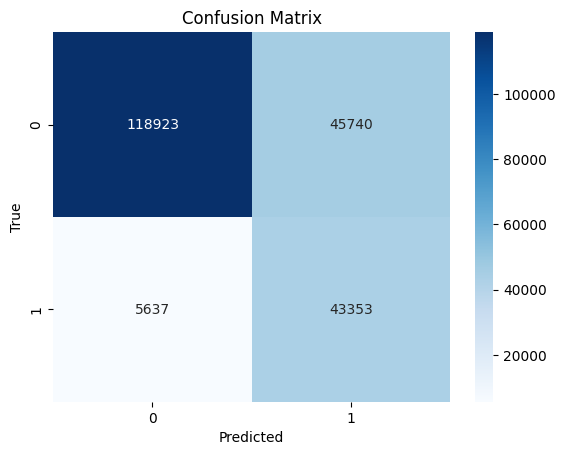

              precision    recall  f1-score   support

           0       0.95      0.72      0.82    164663
           1       0.49      0.88      0.63     48990

    accuracy                           0.76    213653
   macro avg       0.72      0.80      0.73    213653
weighted avg       0.85      0.76      0.78    213653



In [12]:
train_and_evaluate_cat(X_train_scaled, y_train, X_test_scaled, y_test,  class_weights=class_weights)

## Data tune

[I 2025-05-05 19:28:44,676] A new study created in memory with name: no-name-e94badb1-9635-4b58-96ec-c42b8dc58cd2
[I 2025-05-05 19:29:08,703] Trial 0 finished with value: 0.6634596776423102 and parameters: {'iterations': 387, 'learning_rate': 0.2086359711643517, 'depth': 5, 'l2_leaf_reg': 9.141992985300652, 'random_strength': 0.7410215936411033, 'bagging_temperature': 0.9906884452739783, 'threshold': 0.35}. Best is trial 0 with value: 0.6634596776423102.
[I 2025-05-05 19:30:19,473] Trial 1 finished with value: 0.5171620325982743 and parameters: {'iterations': 329, 'learning_rate': 0.11570651336079338, 'depth': 10, 'l2_leaf_reg': 9.28392809455246, 'random_strength': 0.22051188592806154, 'bagging_temperature': 0.10649109143102198, 'threshold': 0.7000000000000001}. Best is trial 0 with value: 0.6634596776423102.
[I 2025-05-05 19:30:55,099] Trial 2 finished with value: 0.42439859891678366 and parameters: {'iterations': 400, 'learning_rate': 0.010128194803367635, 'depth': 8, 'l2_leaf_reg': 

Best trial:
FrozenTrial(number=41, state=1, values=[0.6776016617699347], datetime_start=datetime.datetime(2025, 5, 5, 19, 44, 51, 423116), datetime_complete=datetime.datetime(2025, 5, 5, 19, 45, 2, 529033), params={'iterations': 145, 'learning_rate': 0.07109704082496446, 'depth': 7, 'l2_leaf_reg': 3.4527761017873058, 'random_strength': 0.9544783717422651, 'bagging_temperature': 0.8524193919526528, 'threshold': 0.35}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, s

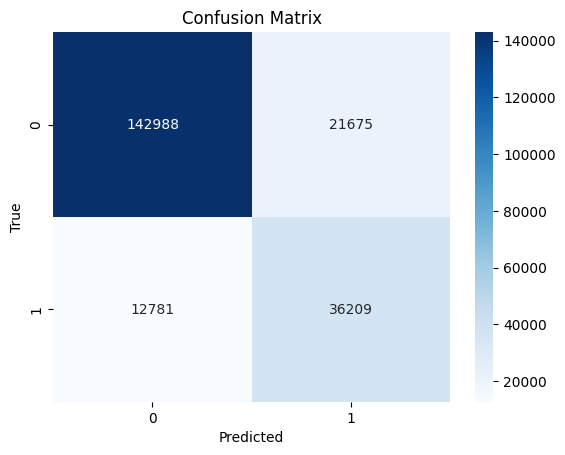

              precision    recall  f1-score   support

           0       0.92      0.87      0.89    164663
           1       0.63      0.74      0.68     48990

    accuracy                           0.84    213653
   macro avg       0.77      0.80      0.79    213653
weighted avg       0.85      0.84      0.84    213653



In [13]:
optimize_and_train_catboost(X_train_scaled, y_train, X_test_scaled, y_test)

## Data + feature

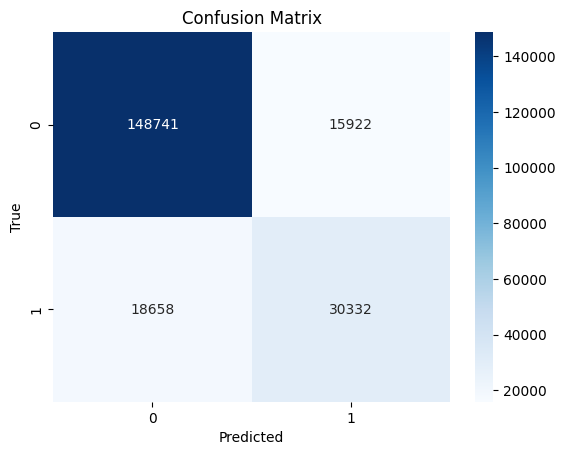

              precision    recall  f1-score   support

           0       0.89      0.90      0.90    164663
           1       0.66      0.62      0.64     48990

    accuracy                           0.84    213653
   macro avg       0.77      0.76      0.77    213653
weighted avg       0.84      0.84      0.84    213653



In [14]:
train_and_evaluate_cat(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + Feature + Tune

[I 2025-05-05 19:48:11,058] A new study created in memory with name: no-name-18c3e2d2-1e2e-404b-a0e5-fe1950a220fc
[I 2025-05-05 19:48:34,207] Trial 0 finished with value: 0.5879083197978704 and parameters: {'iterations': 333, 'learning_rate': 0.27027434269948836, 'depth': 8, 'l2_leaf_reg': 2.183890645126642, 'random_strength': 0.32250836300980956, 'bagging_temperature': 0.537406840104411, 'threshold': 0.65}. Best is trial 0 with value: 0.5879083197978704.
[I 2025-05-05 19:48:40,554] Trial 1 finished with value: 0.13717182416584703 and parameters: {'iterations': 172, 'learning_rate': 0.12276365415516474, 'depth': 5, 'l2_leaf_reg': 1.2415009040646405, 'random_strength': 0.14976121783389099, 'bagging_temperature': 0.49071668629215515, 'threshold': 0.9}. Best is trial 0 with value: 0.5879083197978704.
[I 2025-05-05 19:49:00,633] Trial 2 finished with value: 0.5570753133887197 and parameters: {'iterations': 233, 'learning_rate': 0.04355793548711452, 'depth': 9, 'l2_leaf_reg': 9.173832852441

Best trial:
FrozenTrial(number=5, state=1, values=[0.6638334948478355], datetime_start=datetime.datetime(2025, 5, 5, 19, 49, 44, 715965), datetime_complete=datetime.datetime(2025, 5, 5, 19, 49, 49, 847068), params={'iterations': 158, 'learning_rate': 0.2218453010081081, 'depth': 5, 'l2_leaf_reg': 3.273955936791896, 'random_strength': 0.6792930146929401, 'bagging_temperature': 0.1895854420657539, 'threshold': 0.35}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, ste

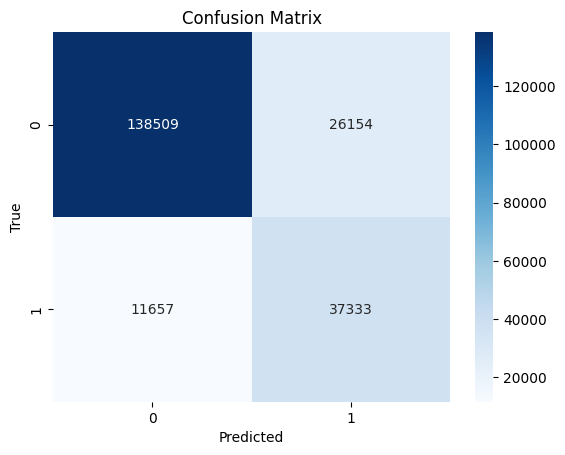

              precision    recall  f1-score   support

           0       0.92      0.84      0.88    164663
           1       0.59      0.76      0.66     48990

    accuracy                           0.82    213653
   macro avg       0.76      0.80      0.77    213653
weighted avg       0.85      0.82      0.83    213653



In [15]:
optimize_and_train_catboost(X_train_scaled, y_train, X_test_scaled, y_test, top_features=top_features)

## Data + class_weights

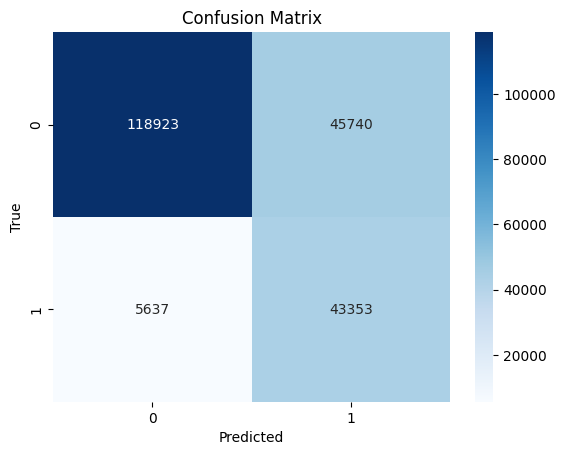

              precision    recall  f1-score   support

           0       0.95      0.72      0.82    164663
           1       0.49      0.88      0.63     48990

    accuracy                           0.76    213653
   macro avg       0.72      0.80      0.73    213653
weighted avg       0.85      0.76      0.78    213653



In [16]:
train_and_evaluate_cat(X_train_scaled, y_train, X_test_scaled, y_test, class_weights=class_weights)

## Data + class_weights + Tune

[I 2025-05-05 20:02:16,101] A new study created in memory with name: no-name-64a564c5-d129-47b5-a15e-a29e3e66aca0
[I 2025-05-05 20:02:26,465] Trial 0 finished with value: 0.6588380910600695 and parameters: {'iterations': 109, 'learning_rate': 0.10087473039052869, 'depth': 8, 'l2_leaf_reg': 6.546264719287987, 'random_strength': 0.7990761586098932, 'bagging_temperature': 0.5399315966256707, 'threshold': 0.75}. Best is trial 0 with value: 0.6588380910600695.
[I 2025-05-05 20:02:54,790] Trial 1 finished with value: 0.4901872172319066 and parameters: {'iterations': 303, 'learning_rate': 0.010413428588315113, 'depth': 8, 'l2_leaf_reg': 2.8085293608902893, 'random_strength': 0.47532563042909326, 'bagging_temperature': 0.4480160221952951, 'threshold': 0.25}. Best is trial 0 with value: 0.6588380910600695.
[I 2025-05-05 20:03:25,984] Trial 2 finished with value: 0.6245654272421777 and parameters: {'iterations': 456, 'learning_rate': 0.29518506351962176, 'depth': 6, 'l2_leaf_reg': 4.160565394220

Best trial:
FrozenTrial(number=19, state=1, values=[0.6737706181593957], datetime_start=datetime.datetime(2025, 5, 5, 20, 9, 32, 430358), datetime_complete=datetime.datetime(2025, 5, 5, 20, 9, 56, 263416), params={'iterations': 367, 'learning_rate': 0.12375402983936669, 'depth': 5, 'l2_leaf_reg': 8.37050552929717, 'random_strength': 0.7175994810855841, 'bagging_temperature': 0.9790977360928897, 'threshold': 0.85}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step

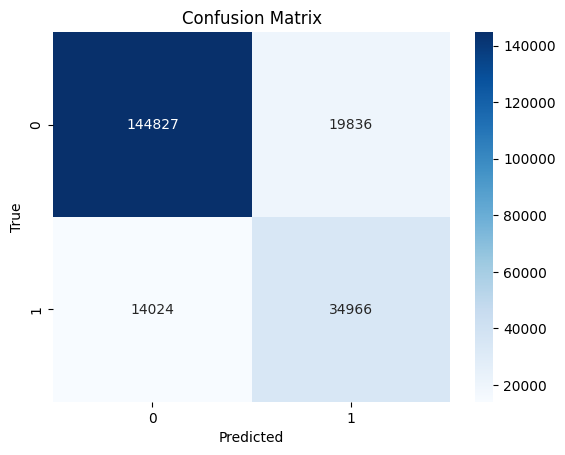

              precision    recall  f1-score   support

           0       0.91      0.88      0.90    164663
           1       0.64      0.71      0.67     48990

    accuracy                           0.84    213653
   macro avg       0.77      0.80      0.78    213653
weighted avg       0.85      0.84      0.84    213653



In [17]:
optimize_and_train_catboost(X_train_scaled, y_train, X_test_scaled, y_test,class_weights=class_weights)

## Data + class_weights + feature 

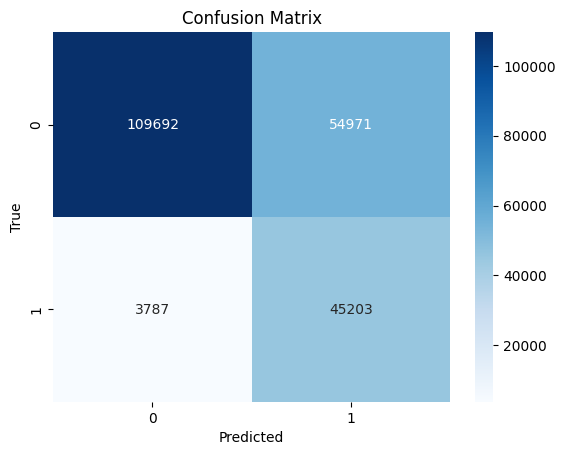

              precision    recall  f1-score   support

           0       0.97      0.67      0.79    164663
           1       0.45      0.92      0.61     48990

    accuracy                           0.72    213653
   macro avg       0.71      0.79      0.70    213653
weighted avg       0.85      0.72      0.75    213653



In [18]:
train_and_evaluate_cat(X_train_scaled, y_train, X_test_scaled, y_test, class_weights=class_weights, top_features=top_features)

## Data + class_weights + feature + tune

[I 2025-05-05 20:29:11,641] A new study created in memory with name: no-name-d23bc65a-382c-469b-961f-1617f3146705
[I 2025-05-05 20:29:34,123] Trial 0 finished with value: 0.6532075609400088 and parameters: {'iterations': 467, 'learning_rate': 0.05648273610389415, 'depth': 4, 'l2_leaf_reg': 9.870278636621268, 'random_strength': 0.20805442511789554, 'bagging_temperature': 0.7173346130534758, 'threshold': 0.85}. Best is trial 0 with value: 0.6532075609400088.
[I 2025-05-05 20:29:40,514] Trial 1 finished with value: 0.5795837015587687 and parameters: {'iterations': 148, 'learning_rate': 0.18037787444265244, 'depth': 7, 'l2_leaf_reg': 6.664764715172021, 'random_strength': 0.9296902104770897, 'bagging_temperature': 0.32954930470650357, 'threshold': 0.55}. Best is trial 0 with value: 0.6532075609400088.
[I 2025-05-05 20:29:44,837] Trial 2 finished with value: 0.4578251864712238 and parameters: {'iterations': 141, 'learning_rate': 0.04325752531398859, 'depth': 4, 'l2_leaf_reg': 5.9640686439988

Best trial:
FrozenTrial(number=42, state=1, values=[0.6647671127740202], datetime_start=datetime.datetime(2025, 5, 5, 20, 41, 37, 375049), datetime_complete=datetime.datetime(2025, 5, 5, 20, 41, 42, 696404), params={'iterations': 136, 'learning_rate': 0.05849147330883441, 'depth': 6, 'l2_leaf_reg': 4.418034942345845, 'random_strength': 0.7202553491170799, 'bagging_temperature': 0.670322990286891, 'threshold': 0.85}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, st

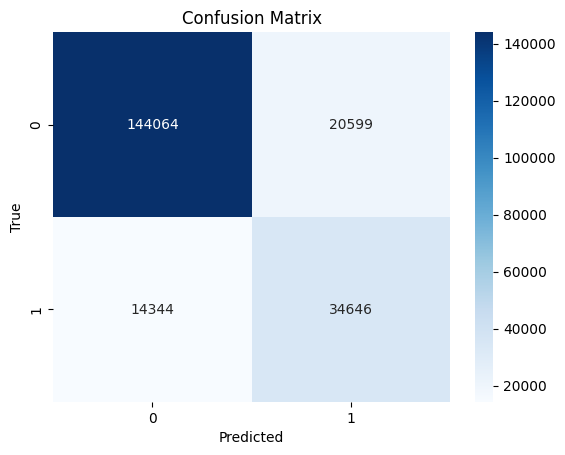

              precision    recall  f1-score   support

           0       0.91      0.87      0.89    164663
           1       0.63      0.71      0.66     48990

    accuracy                           0.84    213653
   macro avg       0.77      0.79      0.78    213653
weighted avg       0.84      0.84      0.84    213653



In [19]:
optimize_and_train_catboost(X_train_scaled, y_train, X_test_scaled, y_test,class_weights=class_weights, top_features = top_features)

# SMOTE

In [20]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE 

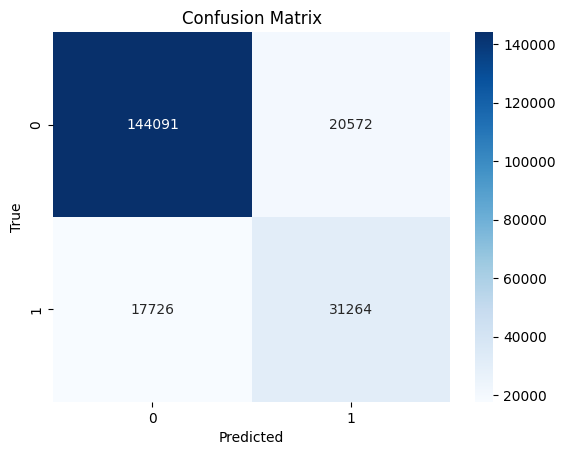

              precision    recall  f1-score   support

           0       0.89      0.88      0.88    164663
           1       0.60      0.64      0.62     48990

    accuracy                           0.82    213653
   macro avg       0.75      0.76      0.75    213653
weighted avg       0.82      0.82      0.82    213653



In [21]:
train_and_evaluate_cat(X_train_scaled, y_sm, X_test_scaled, y_test)

## Data SMOTE + Tune

[I 2025-05-05 20:45:05,696] A new study created in memory with name: no-name-831fb19b-db6e-457a-9342-9f678c04413c
[I 2025-05-05 20:45:29,897] Trial 0 finished with value: 0.5721042803086146 and parameters: {'iterations': 196, 'learning_rate': 0.05268877643956191, 'depth': 6, 'l2_leaf_reg': 8.140200193405025, 'random_strength': 0.5745249946697675, 'bagging_temperature': 0.4028646579196905, 'threshold': 0.30000000000000004}. Best is trial 0 with value: 0.5721042803086146.
[I 2025-05-05 20:46:09,950] Trial 1 finished with value: 0.6165635595954092 and parameters: {'iterations': 113, 'learning_rate': 0.06523100514709881, 'depth': 10, 'l2_leaf_reg': 4.75252745396318, 'random_strength': 0.5232947809819428, 'bagging_temperature': 0.5579919426125733, 'threshold': 0.45000000000000007}. Best is trial 1 with value: 0.6165635595954092.
[I 2025-05-05 20:46:22,015] Trial 2 finished with value: 0.5577685465567611 and parameters: {'iterations': 121, 'learning_rate': 0.13203119111577621, 'depth': 4, 'l

Best trial:
FrozenTrial(number=37, state=1, values=[0.6697283383641043], datetime_start=datetime.datetime(2025, 5, 5, 21, 9, 26, 31045), datetime_complete=datetime.datetime(2025, 5, 5, 21, 10, 2, 265928), params={'iterations': 324, 'learning_rate': 0.13175818694145483, 'depth': 5, 'l2_leaf_reg': 3.460835825297478, 'random_strength': 0.27463759525968456, 'bagging_temperature': 0.7226551963937311, 'threshold': 0.65}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, ste

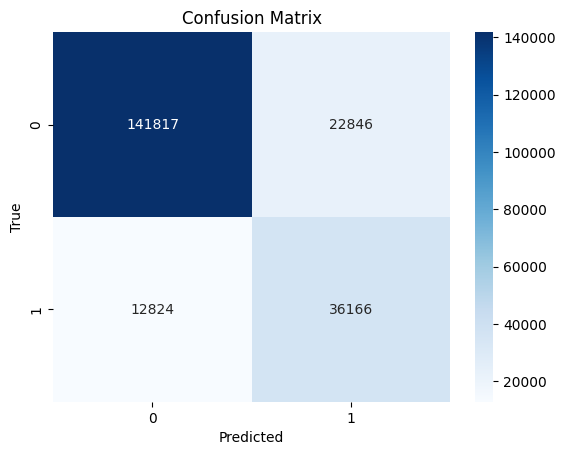

              precision    recall  f1-score   support

           0       0.92      0.86      0.89    164663
           1       0.61      0.74      0.67     48990

    accuracy                           0.83    213653
   macro avg       0.76      0.80      0.78    213653
weighted avg       0.85      0.83      0.84    213653



In [22]:
optimize_and_train_catboost(X_train_scaled, y_sm, X_test_scaled, y_test, use_smote=True)

## Data SMOTE + Feature

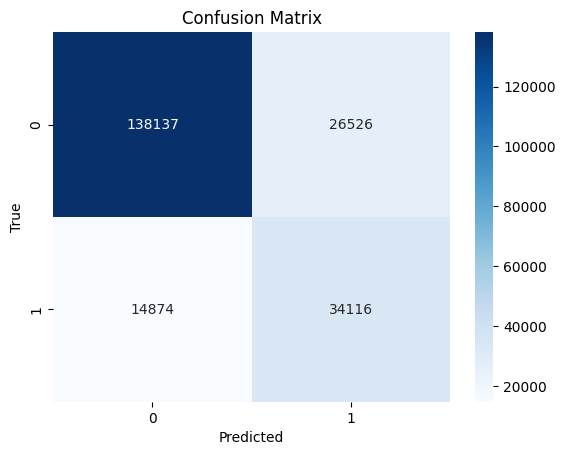

              precision    recall  f1-score   support

           0       0.90      0.84      0.87    164663
           1       0.56      0.70      0.62     48990

    accuracy                           0.81    213653
   macro avg       0.73      0.77      0.75    213653
weighted avg       0.82      0.81      0.81    213653



In [23]:
train_and_evaluate_cat(X_train_scaled, y_sm, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE + Feature + Tune

[I 2025-05-05 21:18:59,419] A new study created in memory with name: no-name-96a28219-1017-49b6-8159-2f5c824971c6
[I 2025-05-05 21:19:22,967] Trial 0 finished with value: 0.6280083672795332 and parameters: {'iterations': 134, 'learning_rate': 0.16267823479344434, 'depth': 10, 'l2_leaf_reg': 9.080878183413335, 'random_strength': 0.8797666392159541, 'bagging_temperature': 0.2821400662838449, 'threshold': 0.8}. Best is trial 0 with value: 0.6280083672795332.
[I 2025-05-05 21:19:52,315] Trial 1 finished with value: 0.6394724329043472 and parameters: {'iterations': 364, 'learning_rate': 0.2140536427841769, 'depth': 4, 'l2_leaf_reg': 2.026832086434907, 'random_strength': 0.3641439272388711, 'bagging_temperature': 0.8036580154318569, 'threshold': 0.5}. Best is trial 1 with value: 0.6394724329043472.
[I 2025-05-05 21:20:20,793] Trial 2 finished with value: 0.5342608499732446 and parameters: {'iterations': 315, 'learning_rate': 0.1017980416553245, 'depth': 5, 'l2_leaf_reg': 4.110721031436055, '

Best trial:
FrozenTrial(number=38, state=1, values=[0.6545229696306208], datetime_start=datetime.datetime(2025, 5, 5, 21, 40, 16, 324057), datetime_complete=datetime.datetime(2025, 5, 5, 21, 40, 46, 222157), params={'iterations': 296, 'learning_rate': 0.10776431011547126, 'depth': 6, 'l2_leaf_reg': 5.646322482594404, 'random_strength': 0.5034185449834329, 'bagging_temperature': 0.3744647756799987, 'threshold': 0.75}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, s

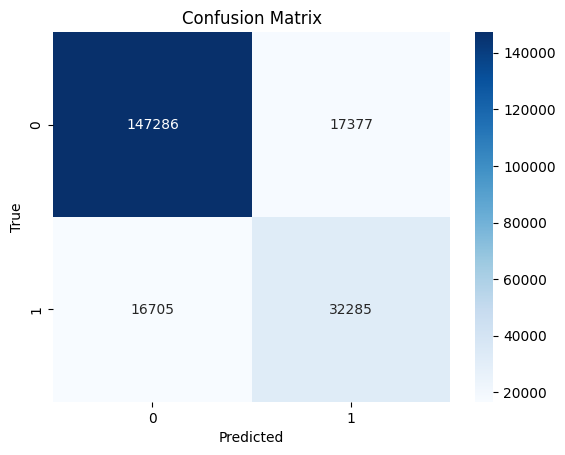

              precision    recall  f1-score   support

           0       0.90      0.89      0.90    164663
           1       0.65      0.66      0.65     48990

    accuracy                           0.84    213653
   macro avg       0.77      0.78      0.78    213653
weighted avg       0.84      0.84      0.84    213653



In [24]:
optimize_and_train_catboost(X_train_scaled, y_sm, X_test_scaled, y_test, top_features=top_features, use_smote = True)

# SMOTE ENN

In [25]:
smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Data SMOTE ENN 

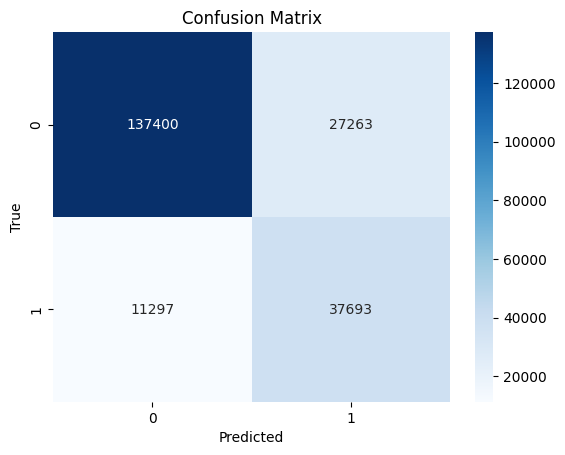

              precision    recall  f1-score   support

           0       0.92      0.83      0.88    164663
           1       0.58      0.77      0.66     48990

    accuracy                           0.82    213653
   macro avg       0.75      0.80      0.77    213653
weighted avg       0.85      0.82      0.83    213653



In [26]:
train_and_evaluate_cat(X_train_scaled, y_smenn, X_test_scaled, y_test)

## Data SMOTE ENN + Tune

[I 2025-05-05 22:18:05,106] A new study created in memory with name: no-name-01616be8-495e-4653-a10e-7d9c3847d9de
[I 2025-05-05 22:18:30,825] Trial 0 finished with value: 0.611122138028465 and parameters: {'iterations': 362, 'learning_rate': 0.07265960624673365, 'depth': 3, 'l2_leaf_reg': 3.3212533233835155, 'random_strength': 0.8895806979089161, 'bagging_temperature': 0.9732807033705217, 'threshold': 0.9}. Best is trial 0 with value: 0.611122138028465.
[I 2025-05-05 22:19:02,623] Trial 1 finished with value: 0.5867566772787133 and parameters: {'iterations': 286, 'learning_rate': 0.22485094168183867, 'depth': 7, 'l2_leaf_reg': 4.997160894807578, 'random_strength': 0.6827056391640195, 'bagging_temperature': 0.8847689508085098, 'threshold': 0.1}. Best is trial 0 with value: 0.611122138028465.
[I 2025-05-05 22:19:22,185] Trial 2 finished with value: 0.5564952038511125 and parameters: {'iterations': 250, 'learning_rate': 0.09506279484843454, 'depth': 4, 'l2_leaf_reg': 1.9789319885527108, '

Best trial:
FrozenTrial(number=43, state=1, values=[0.678846478160661], datetime_start=datetime.datetime(2025, 5, 5, 22, 41, 14, 457008), datetime_complete=datetime.datetime(2025, 5, 5, 22, 41, 53, 771340), params={'iterations': 500, 'learning_rate': 0.11401152825250832, 'depth': 4, 'l2_leaf_reg': 3.732585600016707, 'random_strength': 0.45140479258379085, 'bagging_temperature': 0.7615490671106934, 'threshold': 0.75}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, s

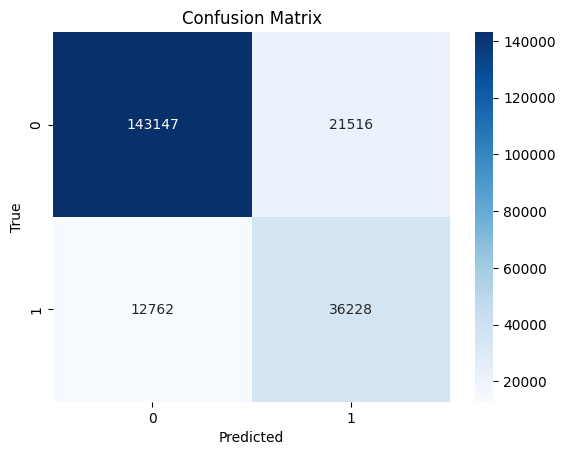

              precision    recall  f1-score   support

           0       0.92      0.87      0.89    164663
           1       0.63      0.74      0.68     48990

    accuracy                           0.84    213653
   macro avg       0.77      0.80      0.79    213653
weighted avg       0.85      0.84      0.84    213653



In [27]:
optimize_and_train_catboost(X_train_scaled, y_smenn, X_test_scaled, y_test, use_smoteenn = True)

## Data SMOTE ENN + Feature

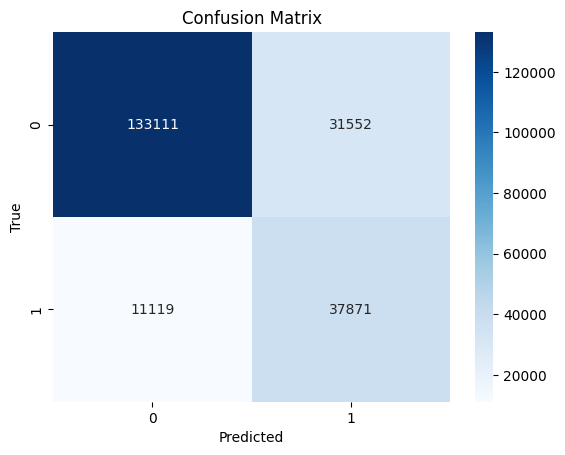

              precision    recall  f1-score   support

           0       0.92      0.81      0.86    164663
           1       0.55      0.77      0.64     48990

    accuracy                           0.80    213653
   macro avg       0.73      0.79      0.75    213653
weighted avg       0.84      0.80      0.81    213653



In [28]:
train_and_evaluate_cat(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features = top_features)

## Data SMOTE ENN + Feature + Tune

[I 2025-05-05 22:47:16,189] A new study created in memory with name: no-name-62bb6611-79d3-481a-bddd-acab55da4151
[I 2025-05-05 22:48:14,082] Trial 0 finished with value: 0.6458020444745894 and parameters: {'iterations': 310, 'learning_rate': 0.14305391144434298, 'depth': 10, 'l2_leaf_reg': 5.5240856816506945, 'random_strength': 0.9279679340924044, 'bagging_temperature': 0.04960545950229189, 'threshold': 0.7000000000000001}. Best is trial 0 with value: 0.6458020444745894.
[I 2025-05-05 22:48:50,351] Trial 1 finished with value: 0.5460595730866001 and parameters: {'iterations': 306, 'learning_rate': 0.05000848716558802, 'depth': 9, 'l2_leaf_reg': 3.3245352317821872, 'random_strength': 0.5976653066843446, 'bagging_temperature': 0.842555149648587, 'threshold': 0.15000000000000002}. Best is trial 0 with value: 0.6458020444745894.
[I 2025-05-05 22:49:19,958] Trial 2 finished with value: 0.6605453587003403 and parameters: {'iterations': 293, 'learning_rate': 0.15064215292825808, 'depth': 8, 

Best trial:
FrozenTrial(number=31, state=1, values=[0.6726095865489572], datetime_start=datetime.datetime(2025, 5, 5, 23, 2, 34, 236102), datetime_complete=datetime.datetime(2025, 5, 5, 23, 3, 14, 119570), params={'iterations': 445, 'learning_rate': 0.14679977701491911, 'depth': 7, 'l2_leaf_reg': 5.999400600740128, 'random_strength': 0.8715079275041002, 'bagging_temperature': 0.6547945560132123, 'threshold': 0.8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=500, log=False, low=100, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'random_strength': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'threshold': FloatDistribution(high=0.9, log=False, low=0.1, step

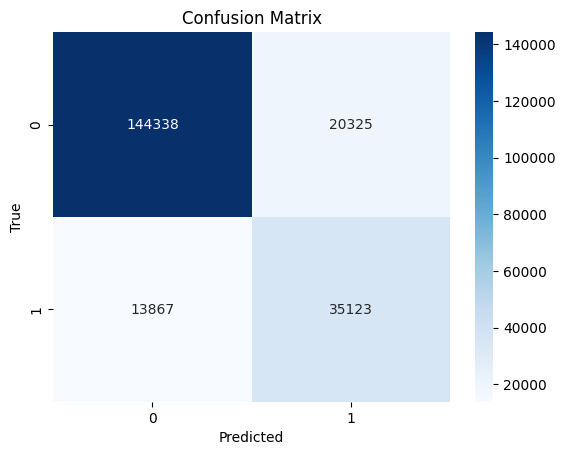

              precision    recall  f1-score   support

           0       0.91      0.88      0.89    164663
           1       0.63      0.72      0.67     48990

    accuracy                           0.84    213653
   macro avg       0.77      0.80      0.78    213653
weighted avg       0.85      0.84      0.84    213653



In [29]:
optimize_and_train_catboost(X_train_scaled, y_smenn, X_test_scaled, y_test, top_features=top_features,  use_smoteenn = True)